# Intro

I am given the task of creating a model that will help the telecom operator Interconnect be able to foresee the churn of their clients. This helps them know when to start offering promotional codes and special plan offers to try and keep their business. I will begin by preprocessing the data to ensure it is complete and accurate, then I will move on to EDA. This will gain more insight on the data and hopefully provide helpful information to Interconnect. Then finally, I will build a machine learning model that will be able to predict if a customer will be leaving or staying with their company. This project will hopefully aid Interconnect with battling a negative churn rate and improve customer satisfaction as well. 

# Load the data

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb 
from sklearn.dummy import DummyClassifier 

In [35]:
# load the data 
contract = pd.read_csv('/datasets/final_provider/contract.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')

# Preprocessing

In [36]:
# merging all four into one dataset 
df = contract.merge(phone, on='customerID', how='outer') \
            .merge(personal, on='customerID', how='outer') \
            .merge(internet, on='customerID', how='outer')
df.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3106,2817-LVCPP,2015-12-01,No,Two year,No,Credit card (automatic),19.40,1023.95,No,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,6908-VVYHM,2014-09-01,No,Month-to-month,Yes,Electronic check,90.65,5931,Yes,Male,0,Yes,No,Fiber optic,No,Yes,No,No,No,Yes
4383,1088-CNNKB,2014-11-01,No,One year,No,Credit card (automatic),80.00,5040.2,Yes,Male,0,Yes,No,DSL,Yes,Yes,Yes,Yes,No,Yes
6043,6338-AVWCY,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,40.15,130.75,NaN,Male,0,No,No,DSL,No,No,Yes,No,Yes,No
1817,5663-QBGIS,2014-02-01,No,Two year,No,Bank transfer (automatic),98.35,6929.4,Yes,Male,1,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes
2317,6770-UAYGJ,2016-01-01,No,Two year,No,Mailed check,25.25,1211.65,Yes,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2806,3259-QMXUN,2015-04-01,No,Two year,Yes,Electronic check,86.10,4890.5,Yes,Male,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
2064,7061-OVMIM,2017-08-01,No,One year,No,Bank transfer (automatic),19.55,608.5,No,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6347,7718-RXDGG,2018-11-01,No,Month-to-month,Yes,Bank transfer (automatic),68.60,1108.6,No,Male,0,Yes,No,Fiber optic,No,No,No,No,No,No
4642,5458-CQJTA,2014-08-01,2020-01-01 00:00:00,Two year,Yes,Bank transfer (automatic),74.80,4820.15,No,Male,0,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes


I merged all four of the data sets into one single dataframe where all information about the services and the customer is available at hand. They were joined by the 'customerID' column with an outer merge to ensure each person was included in the final dataframe. I will continue below with the preprocessing to ensure the data is correct and intact.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   MultipleLines     6361 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [38]:
# checking if the 'internet' set has less rows than the rest causing the main change in numbers 
internet.shape, phone.shape

((5517, 8), (6361, 2))

There doesn't appear to be any missing values from the independent dataframes, but there is undoubtedly some NaN values produces from uneven amounts of rows after being merged. That will be looked into further on how to handle those values below. Also, most are fine, but some data types need to be adjusted to better represent the information from the column and to be more aligned with the goal of the project. 

In [39]:
# correcting dtypes
# convert to datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce') 
# convert to numeric 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# converting to a string and changing '0' to 'No' and '1' to 'Yes' to make it more uniform with the rest of the columns
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype('object') 

Verifying changes below.

In [40]:
df.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
MultipleLines               object
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
dtype: object

In [41]:
df.sample()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3068,1810-BOHSY,2015-11-01,NaT,One year,Yes,Credit card (automatic),96.4,4911.05,Yes,Male,No,Yes,No,Fiber optic,Yes,Yes,No,No,No,Yes


Now that the dtypes are corrected, I will now focus on the NaN values.

In [42]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

Almost all of these NaN values are making sense as being from the a difference in rows from the merge - and the ones from 'EndDate' being the 'No' values. There are only a few from the 'TotalCharges' column that were not previously accounted for. Thankfully, none of the genuine missing values account to a large concerning amount of the set. These can be filled with the median value to maintain data integrity. I will be leaving the NaT values from the EndDate column as there would be no other good value I could fill it with that would be representative at an efficient capacity. This way, I will still be able to access the components of this column while avoiding any confusion. 

In [43]:
# filling missing values with the median 
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
# filling with the mode
df['MultipleLines'] = df['MultipleLines'].fillna(df['MultipleLines'].mode()[0])
df['InternetService'] = df['InternetService'].fillna(df['InternetService'].mode()[0])
# Logical Fill - if no internet service then it's a no for the rest of the service columns as well
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'] 
for col in service_cols:
    df.loc[df['InternetService'] == 'No', col] = 'No'
    df[col] = df[col].fillna(df[col].mode()[0]) 

In [44]:
# verifying changes 
df.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
MultipleLines          0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
dtype: int64

Missing values filled. I will now check for duplicates.

In [45]:
df.duplicated().sum()

0

Data is intact and ready for EDA. I will gather some last information then continue with the analysis.

In [46]:
df.shape

(7043, 20)

In [47]:
df.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2281.916928
std,30.090047,2265.270398
min,18.250000,18.800000
25%,35.500000,402.225000
50%,70.350000,1397.475000
75%,89.850000,3786.600000
max,118.750000,8684.800000


In [48]:
df.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5819,3396-DKDEL,2014-04-01,NaT,Two year,Yes,Credit card (automatic),115.15,8250.00,Yes,Female,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
5118,7621-VPNET,2016-08-01,NaT,Month-to-month,Yes,Credit card (automatic),85.90,3729.75,Yes,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,No,No
1824,0794-YVSGE,2014-02-01,NaT,Two year,No,Bank transfer (automatic),20.30,1401.15,No,Male,No,Yes,Yes,Fiber optic,No,No,No,No,No,No
2162,6635-CPNUN,2017-10-01,NaT,Month-to-month,No,Credit card (automatic),96.60,2684.35,Yes,Male,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No
6161,4343-EJVQB,2019-07-01,NaT,Month-to-month,No,Mailed check,74.35,533.60,No,Male,No,No,No,Fiber optic,Yes,No,No,No,No,No


# EDA

Based on the goal of this project, EDA will be geared towards understanding the relationships of different factors that may cause a customer to leave the company. 

In [49]:
# creating a temporary DF to use and modify for EDA specifically
eda_df = df.assign(Churn = df['EndDate'].notna().astype(int))
eda_df['Churn'].value_counts(normalize=True) # 0 = active , 1 = churned 

0    0.73463
1    0.26537
Name: Churn, dtype: float64

This tells me that there is almost three times the amount of customers that are active compared to those that have left. The main takeaway from this information is the fact that there is a very large class imbalance. This will most definitely have an affect on the way the machine learning model will run so this will need to be addressed later. 

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

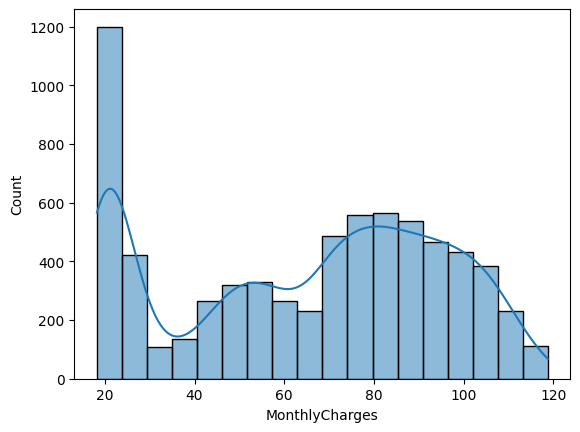

In [50]:
# distribution of monthly charges 
sns.histplot(eda_df['MonthlyCharges'], kde=True)

The histogram above shows the distribution of customers that pay a certain amount monthly. it's visible that the largest amount of customers are associated with those that pay the smallest amount monthly. This suggests that majority of customers have the plans or services that cost the least amount of money. It is also worth noting that there is a secondary spike around $80 a month. Essentially, there are two main groups of customers - those that are paying less for less services, and those that are paying more who have more services with the company. 

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

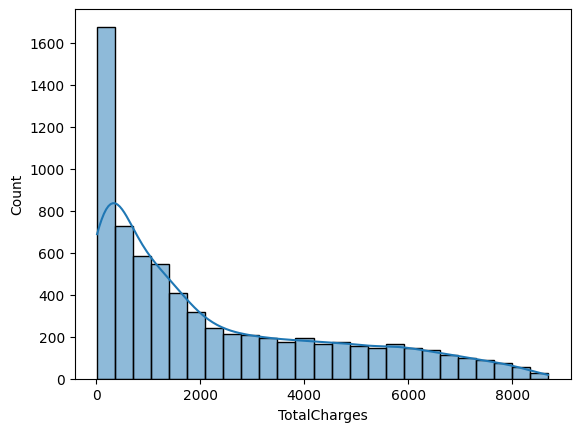

In [51]:
# distribution of total charges 
sns.histplot(eda_df['TotalCharges'], kde=True) 

The above histogram is similar to the previous one in the sense that it is comparing total charges amounts and the amount of customers that fall within those categories. There is a very strong right skew, with a great majority of customers who have less total charges than those who have larger amounts. When trying to apply this information to its logical reasoning, it's natural to assume that this gives a good look at tenure with the company. If there is a client who has been with Interconnect for a long period of time, there would be a larger amount of charges that they have paid over that period. Whereas someone who just started with the company will not have as much history. The main information we can gather from this visual is that the company has many new customers, but not a lot who stay for a longer period of time. 

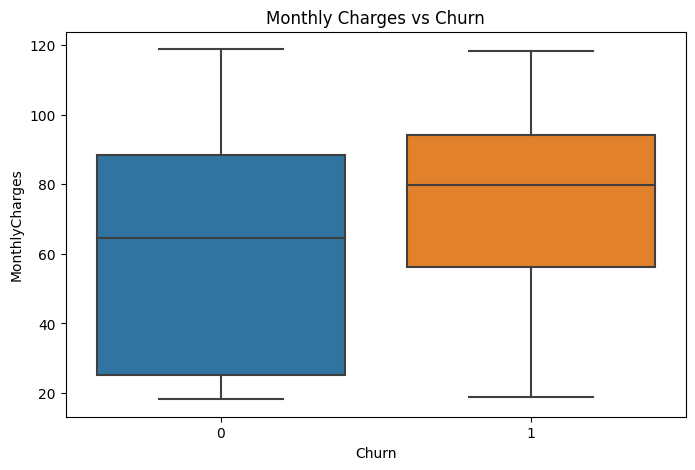

In [52]:
# comparing churn with monthly charges 
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=eda_df)
plt.title("Monthly Charges vs Churn")
plt.show() 

The boxplots above give us a good visual of the relationship between customers who churn and their monthly charges. Due to the plot on the right being shifted upward, we can tell that, typically, the customers who have higher charges tend to churn more often than those with lower charges. 

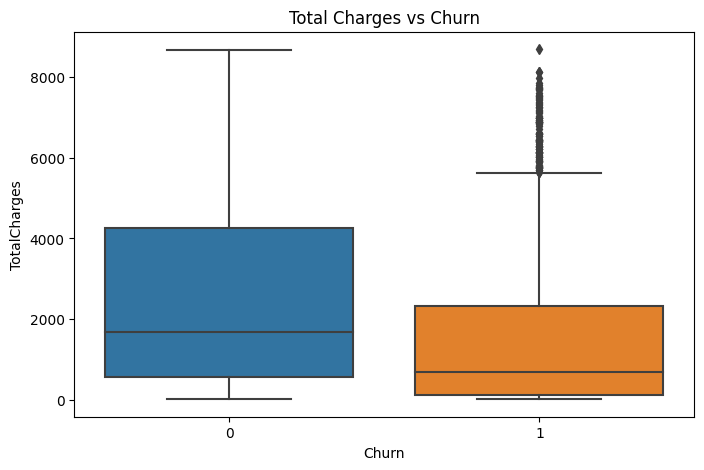

In [53]:
# comparing churn with total charges 
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="TotalCharges", data=eda_df)
plt.title("Total Charges vs Churn")
plt.show() 

This plot, similar to the one above, shows the relationship between churn and total charges. Unlike the one prior to this, churn is more associated with lower total charges rather than larger totals. While this may not immediately make sense, thinking back to our distribution histogram, this may be due to the fact that there may not be as many customers who utilize the company's services long enough to obtain larger total charges. They churn earlier, making churn more associated with the lower total charges.

In [54]:
# looking at churn rate by contract type
eda_df.groupby('Type')['Churn'].mean()

Type
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64

Customers with less commitment to the company have less incentive to stay. So these numbers are making sense. Almost half of all customers who have the month-to-month contracts end up leaving the company.

In [55]:
# churn by payment type
eda_df.groupby('PaymentMethod')['Churn'].mean()

PaymentMethod
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: Churn, dtype: float64

Customers who manually paid each month electronically had the highest rates of churn when compared to all of the ways a customer can submit their payments. The other three ways are similar in their contributed percentages, but those with automatic payments had the lowest amounts. 

In [56]:
# churn by line count 
eda_df.groupby('MultipleLines')['Churn'].mean()

MultipleLines
No     0.250246
Yes    0.286099
Name: Churn, dtype: float64

Churn does not heavily associate with multiple or single line services. 

# ML Preparation

In [57]:
# redefining target feature - 'Churn' - which is a binary transformation of the EndDate column to work better for ML 
df['Churn'] = df['EndDate'].notna().astype(int) # 1 = churned ; 0 = active

In [58]:
# engineering a tenure column from BeginDate and EndDate 
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['TenureMonths'] = ((pd.to_datetime('today') - df['BeginDate']) / np.timedelta64(1, 'M')).astype(int)

In [59]:
# dropping unnecessary columns 
df = df.drop(columns=['BeginDate', 'EndDate', 'customerID']) 

In [60]:
# checking dtypes 
df.dtypes

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
MultipleLines        object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Churn                 int64
TenureMonths          int64
dtype: object

In [61]:
# making sure categorical columns are all correct dtype
cat_cols = [
    'gender', 'Type', 'SeniorCitizen','Partner','Dependents','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod'
]

for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

Leaving the target column 'Churn' as int type to make training easier and to determing the AUC-ROC directly without errors. 

In [62]:
# verifying changes 
df.dtypes

Type                category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
MultipleLines       category
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Churn                  int64
TenureMonths           int64
dtype: object

Splitting before encoding / scaling to avoid leakage.

In [63]:
# splitting - 60train/20valid/20test
target = df['Churn']
features = df.drop('Churn', axis=1)

features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, stratify=target, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, stratify=target_temp, random_state=42) 

In [64]:
# identify categorical and numerical columns
cat_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist() 

In [65]:
# encoding and scaling 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

features_train_processed = preprocessor.fit_transform(features_train)
features_valid_processed = preprocessor.transform(features_valid)
features_test_processed = preprocessor.transform(features_test) 

We know from EDA that there is a large class imbalance. I'll first attempt to handle this with class weights (better for some models and resampling can sometimes distort the data).

In [67]:
# handling class imbalance with class weights
classes = np.unique(target_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weight_dict = dict(zip(classes, class_weights)) 

Data is now prepared for model training. 

# Model Training

The first model to be trained will be a Logistic Regression model since it will work well with the class weights, and the scaled numeric features.

In [68]:
# LR model
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(features_train_processed, target_train)

target_valid_pred_lr = lr.predict(features_valid_processed)
target_valid_proba_lr = lr.predict_proba(features_valid_processed)[:, 1]

print("Logistic Regression - AUC-ROC:", roc_auc_score(target_valid, target_valid_proba_lr))
print("Logistic Regression - Accuracy:", accuracy_score(target_valid, target_valid_pred_lr)) 

Logistic Regression - AUC-ROC: 0.8454054612622388
Logistic Regression - Accuracy: 0.7366926898509581


This model is already performing relatively well and close to the metrics needed.

The next model will be a RandomForest model as it can be simple to tune but still works well with the given data.

In [69]:
# RF model
rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
rf.fit(features_train_processed, target_train)

target_valid_pred_rf = rf.predict(features_valid_processed)
target_valid_proba_rf = rf.predict_proba(features_valid_processed)[:, 1]

print("Random Forest - AUC-ROC:", roc_auc_score(target_valid, target_valid_proba_rf))
print("Random Forest - Accuracy:", accuracy_score(target_valid, target_valid_pred_rf)) 

Random Forest - AUC-ROC: 0.8736237050815054
Random Forest - Accuracy: 0.8360539389638041


This model has great numbers for both metrics! Let's see if we can get something even better though with this next model.

The last model I will train with will be the Gradient Boosting model. This model is great with the AUC-ROC metric and handles non-linearity well.

In [70]:
# GB model 
# compute scale_pos_weight for this specific model
scale_pos_weight = target_train.value_counts()[0] / target_train.value_counts()[1]

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42) 

xgb_clf.fit(features_train_processed, target_train) 

target_valid_pred_xgb = xgb_clf.predict(features_valid_processed)
target_valid_proba_xgb = xgb_clf.predict_proba(features_valid_processed)[:, 1]

print("XGBoost - AUC-ROC:", roc_auc_score(target_valid, target_valid_proba_xgb))
print("XGBoost - Accuracy:", accuracy_score(target_valid, target_valid_pred_xgb)) 

XGBoost - AUC-ROC: 0.9314371334831694
XGBoost - Accuracy: 0.8921220723917672


The Gradient Boosting model far exceeded the criteria for both metrics! This will be the model moving on to final testing.

# Final Testing

In [71]:
# GB final testing on test set 
target_test_proba_final = xgb_clf.predict_proba(features_test_processed)[:, 1] 
target_test_pred_final = xgb_clf.predict(features_test_processed)               

test_auc = roc_auc_score(target_test, target_test_proba_final)
test_acc = accuracy_score(target_test, target_test_pred_final)

print(f"Final Test AUC-ROC: {test_auc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}") 

Final Test AUC-ROC: 0.9120
Final Test Accuracy: 0.8652


The model is performing well and meets requirements. Although there is a small drop in AUC-ROC and accuracy, that is normal and likely due to randomness and new patterns that have yet to be seen by the model. But overall, the model generalizes well and predicts at a high level. 

# Sanity Check

In [73]:
# checking the class balances between the splits
print("Train class distribution:\n", target_train.value_counts(normalize=True))
print("Validation class distribution:\n", target_valid.value_counts(normalize=True))
print("Test class distribution:\n", target_test.value_counts(normalize=True)) 

Train class distribution:
 0    0.734675
1    0.265325
Name: Churn, dtype: float64
Validation class distribution:
 0    0.734564
1    0.265436
Name: Churn, dtype: float64
Test class distribution:
 0    0.734564
1    0.265436
Name: Churn, dtype: float64


The splits maintained their proportions.

In [74]:
# checking prediction outputs 
print("Sample predicted probabilities:", target_test_proba_final[:5])
print("Sample predicted labels:", target_test_pred_final[:5])
print("Unique labels:", np.unique(target_test_pred_final)) 

Sample predicted probabilities: [0.03956183 0.22082548 0.0900748  0.5175655  0.01045945]
Sample predicted labels: [0 0 0 1 0]
Unique labels: [0 1]


The model isn't producing unexpected values and is predicting confidently and accurately. The model is performing well.

In [75]:
# comparing against a dummy classifier 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(features_train_processed, target_train)
dummy_pred = dummy.predict(features_test_processed)
dummy_auc = roc_auc_score(target_test, [0.5]*len(target_test)) 
dummy_acc = accuracy_score(target_test, dummy_pred)

print("Dummy Accuracy:", dummy_acc)
print("Dummy AUC-ROC:", dummy_auc) 

Dummy Accuracy: 0.7345635202271115
Dummy AUC-ROC: 0.5


The model does much better than the dummy model which indicates that the model is genuinely learning the features patterns and predicting beyond the majority class. This tells us it will do great with any future unseen data. 

# Conclusion

The goal of this project was to create a ML model that would be able to assist Interconnect with forecasting the churn of their clients. When loading the data given with this task, there were only a few things to address. The files were merged into one dataset, then I addressed any and all missing values, data type inaccuracies, and duplicates. After quick clean up, I was ready to move on to EDA. Here, I focused on uncovering relationships and different factors that may be contributing to churn. I looked into the distribution of charges that clients were paying both montly and as a total. I also looked at the connections between those distributions and churn. It was found that there were mainly either clients who had the bare minimum with the company or those that had majority of services. It was also found that customers who had low-commitment (in terms of contracts, specifically) with the company had a very high chance of leaving. Also, the company does well with attracting new clients, but not necessarily with longevity of keeping those clients. With this information, it was finally time to move on to model training. It was discovered during EDA that there was a massive class imbalance and there was a good handful of features (which may cause overfitting) - which was carefully considered when choosing the appropriate models. I chose to train LogisticRegression, RandomForest, and a Gradient Boosting model (in that order). Each one performed better than the last. Each model was evaluated with the AUC-ROC and accuracy score metrics, with the best one from the XGB model coming in at 0.93 and 0.89. Final testing with this model produced an AUC-ROC score of 0.91 and an accuracy score of 0.86. The model was doing great at generalizing and working with data it hadn't yet encountered. The sanity check confirmed this and gave confidence that the model was truly learning patterns and was confident in its predictions. I am secure with the decision to be able to present this model to Interconnect for use. This will no doubt be able to assist with pinpointing clients that may be leaving the company and in turn offer services or promotions to keep their satisfaction and loyalty. This will not only benefit the company financially but will also help their reputation and also increase customer experience.  